# Epidemic Spreading on Graphs

In this notebook we model spreading of a disease in a dormitory like enviroment.

First let us import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import interact
import ipywidgets as widgets

Then let us define the parameters for building up the dormitory.

In [2]:
rooms_x = 12
rooms_y = 2
residents_per_room = 2
corridor_width = 4
room_distance = 4

n_residents = rooms_x * rooms_y * residents_per_room

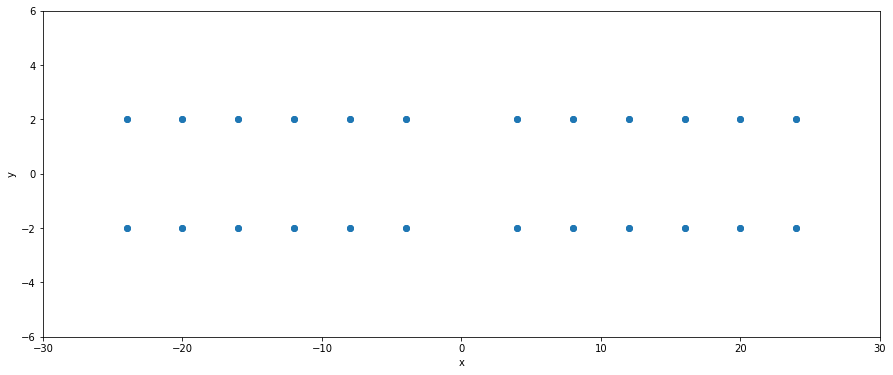

In [3]:
resident_index = 0
resident_coords = np.empty((n_residents, 2))
for x in range(rooms_x):
    for y in range(rooms_y):
        for z in range(residents_per_room):
            x_temp = x  - (rooms_x - 1) / 2
            y_temp = y  - (rooms_y - 1) / 2
            resident_coords[resident_index] = np.array(
                [room_distance * x_temp + np.sign(x_temp) * corridor_width / 2,
                 room_distance * y_temp]
            )
            resident_index += 1

plt.rcParams["figure.figsize"] = (15, 6);
plt.scatter(resident_coords[:, 0], resident_coords[:, 1])
plt.gca().set(xlim=(-30, 30), ylim=(-6, 6))
plt.xlabel("x")
plt.ylabel("y");

Let us define the required parameters.

In [4]:
timestep = 0.1
# Probability of a roommate getting exposed
infection_p_roommate = 1 / 5 * timestep
# Probability of a friend neighbour getting exposed
infection_p_friend = 1 / 7 * timestep
# Probability of a closest neighbour getting exposed
infection_p_max = 1 / 14 * timestep
# Probability of exposed getting infected within a timestep
p_infect = 0.8 * timestep
# Probability of recovery within a timestep
p_recover = 0.2 * timestep
# We simulate for 70 days
n_iterations= int(70 / timestep)
# Number of friendships in total population
friendships = 10

In [5]:
def p_infection(infection_p_max, distance):
    if distance == 0:
        return infection_p_roommate
    return min(infection_p_max, infection_p_max * room_distance / distance)

Now we can build the matrix representing disease transmission probabilities.

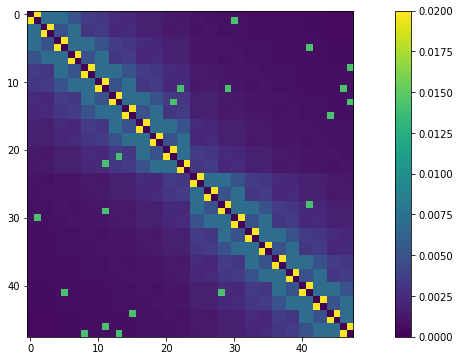

In [6]:
def distance(x1, x2):
    return np.linalg.norm(x1 - x2, 2)

p_matrix = np.zeros((n_residents, n_residents))
for i in range(p_matrix.shape[0]):
    for j in range(p_matrix.shape[1]):
        if i != j:
            p_matrix[i, j] = p_infection(infection_p_max, distance(resident_coords[i], resident_coords[j]))

for i in range(friendships):
    index_1, index_2 = np.random.choice(n_residents, 2, replace=False)
    p_matrix[index_1, index_2] = infection_p_friend
    p_matrix[index_2, index_1] = infection_p_friend

plt.imshow(p_matrix)
plt.colorbar();
#plt.title("Transmission probabilities between residents with time step of 0.1 days")

The function defining the simulation.

In [7]:
def run_simulation(n_initial_exposed, p_matrix, p_infect, p_recover, n_iterations):
    exposed_residents = np.random.choice(n_residents, n_initial_exposed, replace=False).tolist()
    infected_residents = []
    recovered_residents = []
    susceptible_residents = []
    for resident in range(n_residents):
        if resident not in exposed_residents and\
            resident not in infected_residents and\
            resident not in recovered_residents:
            susceptible_residents.append(resident)

    n_susceptible_history = [len(susceptible_residents)]
    n_exposed_history = [len(exposed_residents)]
    n_infected_history = [len(infected_residents)]
    n_recovered_history = [len(recovered_residents)]
    infected_history = []

    for n in range(n_iterations):
        for infected in infected_residents:
            if np.random.rand() < p_recover:
                infected_residents.remove(infected)
                recovered_residents.append(infected)
        for exposed in exposed_residents:
            if np.random.rand() < p_infect:
                exposed_residents.remove(exposed)
                infected_residents.append(exposed)
        for infected in infected_residents:
            for target in range(n_residents):
                if (infected != target and target in susceptible_residents and
                    np.random.rand() < p_matrix[infected, target]):
                    susceptible_residents.remove(target)
                    exposed_residents.append(target)

        n_susceptible_history.append(len(susceptible_residents))
        n_exposed_history.append(len(exposed_residents))
        n_infected_history.append(len(infected_residents))
        n_recovered_history.append(len(recovered_residents))
        infected_history.append(infected_residents.copy())
    
    return {
        'n_susceptible_history': n_susceptible_history,
        'n_exposed_history': n_exposed_history,
        'n_infected_history': n_infected_history,
        'n_recovered_history': n_recovered_history,
        'infected_history': infected_history
    }

Let us run the simulation for 1000 times.

In [8]:
results = []
n_simulations = 1000
for i in range(n_simulations):
    print(f"{100 * (i + 1) / n_simulations}% done")
    clear_output(wait=True)
    results.append(
        run_simulation(
            n_initial_exposed=1,
            p_matrix=p_matrix,
            p_infect=p_infect,
            p_recover=p_recover,
            n_iterations=n_iterations
        )
    )

100.0% done


Now let us plot the number of infected as a function of time for first 20 simulations.

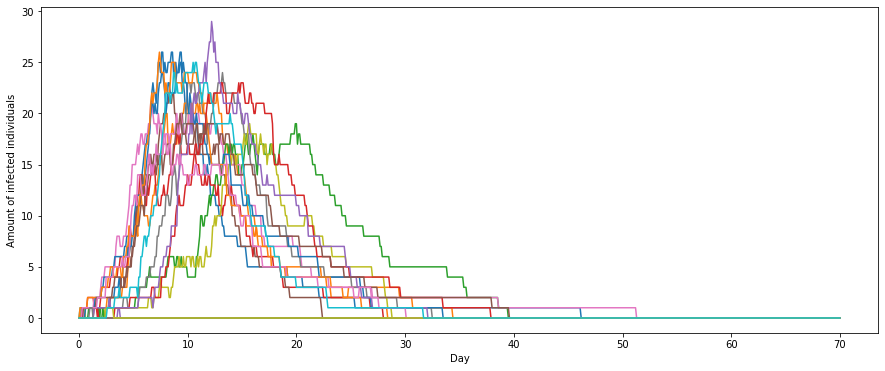

In [9]:
for result in results[:20]:
    plt.plot(
        np.arange(0, len(result['n_infected_history'])) * timestep,
        result['n_infected_history']
    )
plt.ylabel("Amount of infected individuals")
plt.xlabel("Day");

Then let us plot the estimated probability distribution for total amount of people getting infected during the course of a epidemic.

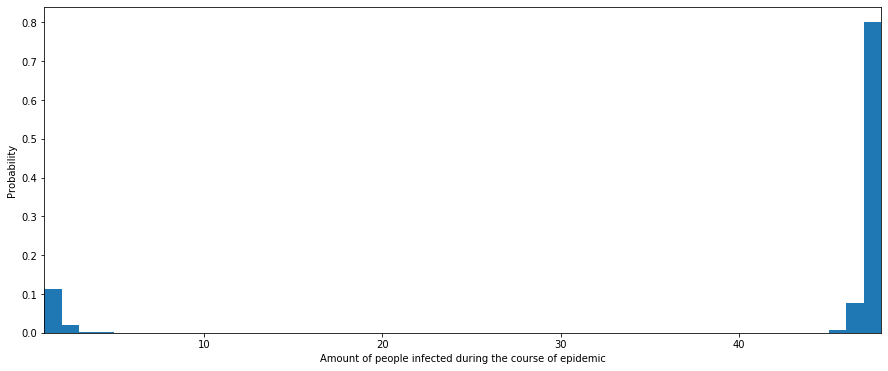

In [10]:
infected = []
for result in results:
    infected.append(n_residents - result['n_susceptible_history'][-1])

plt.hist(infected, bins=48, density=True);
plt.gca().set(xlim=(1, 48));
plt.xlabel("Amount of people infected during the course of epidemic")
plt.ylabel("Probability");

Then let us draw a interact plot of infection spreading in the dormitory. Using the slider one can choose the time instant.

In [11]:
simulation_index = 0

infected_history = results[simulation_index]['infected_history']

def draw_time_instant(time_instant):
    timestep_index = int(time_instant / timestep)
    result = infected_history[timestep_index]
    infected_coords = resident_coords[result]
    plt.scatter(infected_coords[:, 0], infected_coords[:, 1], alpha=0.4)
    plt.gca().set(xlim=(-40, 40), ylim=(-6, 6))
    plt.show()
    print(f"Epidemic after {time_instant} days.")

interact(
    draw_time_instant,
    time_instant=widgets.FloatSlider(
        min=0,
        max=n_iterations * timestep,
        step=timestep,
        value=0,
        continuous_update=True,
        description="Days"
    )
);

interactive(children=(FloatSlider(value=0.0, description='Days', max=70.0), Output()), _dom_classes=('widget-i…